## Cycle GAN

In [0]:
from google.colab import drive
drive.mount('/content/drive')

####Perpared data

In [0]:
cp drive/'My Drive'/Test_DATA/TrainA_11sto20.zip ./

In [0]:
cp drive/'My Drive'/Test_DATA/TrainB_50sto70.zip ./

In [0]:
mkdir datasets

In [0]:
!unzip TrainB_50sto70.zip -d ./datasets/

In [0]:
!unzip TrainA_11sto20.zip  -d ./datasets/

In [0]:
pip install git+https://www.github.com/keras-team/keras-contrib.git

####CycGAN keras

In [0]:
from keras.layers import Layer, Input, Conv2D, Activation, add, BatchNormalization, UpSampling2D, ZeroPadding2D, Conv2DTranspose, Flatten, MaxPooling2D, AveragePooling2D
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization, InputSpec
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.backend import mean
from keras.models import Model
from keras.utils import plot_model
from keras.engine.topology import Network #for untrainable discrimator model but weight still is updated
from keras.callbacks import ModelCheckpoint, TensorBoard

import numpy as np
import random
import datetime
import time

from imageio import imread, imsave
from skimage.transform import resize
from glob import glob

import sys
import os
import cv2
import csv
import matplotlib.pyplot as plt
%matplotlib inline
import keras.backend as kerasbackend
import tensorflow as tf

Using TensorFlow backend.


In [0]:
np.random.seed(seed=123456)

In [0]:
def lrelu(x, leak=0.2, name="lrelu"):
    return tf.maximum(x, leak*x)

In [0]:
#discriminator layer
def d_layer(inputlayer, filter_dim=64, use_normal=True):
  inputlayer = Conv2D(filters=filter_dim, kernel_size=4, strides=2, padding='same')(inputlayer)
  inputlayer = LeakyReLU(alpha=0.2)(inputlayer)
  if use_normal:
      inputlayer = InstanceNormalization(axis=3, center=True, epsilon=1e-5)(inputlayer, training=True)
  return inputlayer

In [0]:
#generator layer
def g_firstLayer(inputlayer, filter_dim=32):
  
  inputlayer = Conv2D(filters=filter_dim, kernel_size=7, strides=1, padding='valid')(inputlayer)
  inputlayer = InstanceNormalization(axis=3, center=True, epsilon=1e-5)(inputlayer, training=True)
  
  inputlayer = Activation('relu')(inputlayer)
  
  return inputlayer

In [0]:
def g_layer(inputlayer, filter_dim=64):
  
  inputlayer = Conv2D(filters=filter_dim, kernel_size=3, strides=2, padding='same')(inputlayer)
  inputlayer = InstanceNormalization(axis=3, center=True, epsilon=1e-5)(inputlayer, training=True)
  
  inputlayer = Activation('relu')(inputlayer)
  
  return inputlayer

In [0]:
# reference class
# reflection padding taken from
# https://github.com/fastai/courses/blob/master/deeplearning2/neural-style.ipynb
class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def compute_output_shape(self, s):
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad, h_pad = self.padding
        return tf.pad(x, [[0, 0], [h_pad, h_pad], [w_pad, w_pad], [0, 0]], 'REFLECT')

In [0]:
def resnet_layer(inputlayer):
  
  filter_size=int(inputlayer.shape[-1])

  #first layer reflection
  layer = ReflectionPadding2D((1,1))(inputlayer)
  layer = Conv2D(filters=filter_size, kernel_size=3, strides=1, padding='valid')(layer)
  layer = Activation('relu')(layer)
  
  #second layer
  layer = ReflectionPadding2D((1,1))(layer)
  layer = Conv2D(filters=filter_size, kernel_size=3, strides=1, padding='valid')(layer)
  
  layer = InstanceNormalization(axis=3, center=True, epsilon=1e-5)(layer, training=True)
  
  resnetlayer = add([layer, inputlayer])
    
  return resnetlayer

In [0]:
def g_upsamplinglayer(inputlayer, filter_dim=64):
  
#   use_resize_convolution  
#   inputlayer = UpSampling2D(size=(2,2))(inputlayer)   
#   inputlayer = ReflectionPadding2D((1,1))(inputlayer)
#   inputlayer = Conv2D(filters=filter_dim, kernel_size=3, strides=1, padding='valid')(inputlayer)
  inputlayer = Conv2DTranspose(filters=filter_dim, kernel_size=3, strides=2, padding='same')(inputlayer)  
  inputlayer = InstanceNormalization(axis=3, center=True, epsilon=1e-5)(inputlayer, training=True)
  inputlayer = Activation('relu')(inputlayer)
  
  return inputlayer

In [0]:
def model_discriminator(name=None):
  
  input_img = Input(shape=img_shape)
  #1st layer no normalization
  layer =d_layer(input_img, 64, use_normal=False)
  #2nd layer with normalizaiont
  layer = d_layer(layer, 64*2, use_normal=True)
  #3rd layer
  layer = d_layer(layer, 64*2*2, use_normal=True)
  #4th layer
  layer = d_layer(layer, 64*2*2*2, use_normal=True)
  #patchgan
  validity=Conv2D(filters=1, kernel_size=4, strides=1, padding='same')(layer)
    
  return Model(inputs=input_img, outputs=validity, name=name)

In [0]:
#build_generator with 9 resnet
def model_generator(name=None):
  
  #input  
  input_img = Input(shape=img_shape)
  
  #layer 1
  output_img = ReflectionPadding2D((3, 3))(input_img)
  
  output_img = g_firstLayer(output_img, 32)

  #layer 2
  output_img = g_layer(output_img, 32*2)

  #layer 3
  output_img = g_layer(output_img, 32*2*2)
  
  #layer 4~12 9 resnet
  for _ in range(4,13):
    output_img = resnet_layer(output_img)
   
  #layer 13 upsamling
  output_img = g_upsamplinglayer(output_img,32*2)
  
  #layer 14 upsamiling
  output_img = g_upsamplinglayer(output_img,32)
 
  output_img = ReflectionPadding2D((3,3))(output_img)
  output_img = Conv2D(filters=channels, kernel_size=7, strides=1)(output_img)
  
  output_img = Activation('tanh')(output_img)

  return Model(inputs=input_img, outputs=output_img, name=name)

In [0]:
def convert_image_array(batch_list, path):
  
  img_array = []
  
  for img in batch_list:
    
    img = imread(img, pilmode='RGB').astype(np.float32)
    img = resize(img, (256, 256))
    img_array.append(img) 
    
  img_array = np.array(img_array) / 127.5 - 1
  return img_array

In [0]:
def loaddata_batch(root_path, batch_size=1, is_testing=False):
  data_type = 'train' if not is_testing else 'test'
  
#   path_A = glob(os.path.join(root_path, data_type+'A', '*.jpg'))
#   path_B = glob(os.path.join(root_path, data_type+'B', '*.jpg'))
  path_A =  glob(os.path.join(root_path, 'TrainA_11sto20', '*.jpg'))
  path_B = glob(os.path.join(root_path, 'TrainB_50sto70', '*.jpg'))

  batch_num = int(min(len(path_A), len(path_B)) / batch_size)
  sample_num = batch_num * batch_size
 
  path_A = np.random.choice(path_A, sample_num, replace=False)
  path_B = np.random.choice(path_B, sample_num, replace=False)
  
  for i in range(batch_num):
    
    batch_A = path_A[i*batch_size: (i+1)*batch_size]
    batch_B = path_B[i*batch_size: (i+1)*batch_size]
    imgs_A = convert_image_array(batch_A, path_A[0])
    imgs_B = convert_image_array(batch_B, path_B[0])
    
    yield batch_num, imgs_A, imgs_B

In [0]:
# #for unit test
# for batch_index, (batch_num,imgs_A, imgs_B) in enumerate(loaddata_batch(root_path, 1)):
#   print(batch_num)
#   print(batch_index)
#   print(imgs_A.shape)
#   print(imgs_B.shape)
#   break

In [0]:
def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    img = np.zeros((h * size[0], w * size[1], 3))
    for idx, image in enumerate(images):
        i = idx % size[1]
        j = idx // size[1]
        img[j*h:j*h+h, i*w:i*w+w, :] = image

    return img

In [0]:
def saveimage(batch_index,epoch_index):
  
  os.makedirs('images', exist_ok=True)
  
  rows, columns = 2, 3
#   img_A = imread('./datasets/horse2zebra/testA/n02381460_1300.jpg',pilmode='RGB').astype(np.float32)
#   img_B = imread('./datasets/horse2zebra/testB/n02391049_2100.jpg',pilmode='RGB').astype(np.float32)
  img_A = imread('./014A18.JPG').astype(np.float32)
  img_B = imread('./048A54.JPG').astype(np.float32)
  img_A = resize(img_A, (256, 256))
  img_B = resize(img_B, (256, 256))
#   normalization
  imgs_A, imgs_B = [],[]
  imgs_A.append(img_A)
  imgs_A = np.array(imgs_A)/127.5 - 1

  imgs_B.append(img_B)
  imgs_B = np.array(imgs_B)/127.5 - 1
  
  #transform other domain
  fake_B = G_A2B.predict(imgs_A)
  fake_A = G_B2A.predict(imgs_B)
  
  #recontract to orginal domain
  recon_A = G_B2A.predict(fake_B)
  recon_B = G_A2B.predict(fake_A)
  
  
  imgs = np.concatenate([imgs_A, fake_B, recon_A, imgs_B, fake_A, recon_B])
#   imsave("images/%s/%d_%d_fakeB.jpg"%(dataset, epoch_index,batch_index),pilmode='RGB',fake_B)
#   imsave("images/%s/%d_%d_fakeA.jpg"%(dataset, epoch_index,batch_index),fake_A.astype(np.uint8))
  
#   plt.imsave("images/%d_%d.jpg"%(epoch_index,batch_index),arr=recon_A[0])
  #rescale image -1 ~1
  imgs = 0.5 * imgs + 0.5
#   imgs = -1 * (1.0 - imgs) + imgs
#   print(batch_index)
  titles = ['orignal', 'transform','goback']
  fig, axs = plt.subplots(rows, columns)
  count = 0
  for i in range(rows):
    for j in range(columns):
      axs[i, j].imshow(imgs[count])
      axs[i, j].set_title(titles[j])
      axs[i, j].axis('off')
      count += 1
  plt.savefig("images/%d_%d.png"%(epoch_index,batch_index))
#   plt.imsave("images/%s/%d_%d.jpg"%(dataset, epoch_index,batch_index),arr=imgs)
  plt.show()
  plt.close()
 
  

In [0]:
#loss function
def lse(y_true, y_pred):
  loss = tf.reduce_mean(tf.squeared_difference(y_pred, y_true))
  return loss

def cycle_loss(y_true, y_pred):
  loss = tf.reduce_mean(tf.abs(y_pred - y_true))
  return loss 
  
#linear decay on learning rate
def update_lr(epoch):
  if epoch < 100:
    lr_D = 2e-4
    lr_G = 2e-4
  else:
    lr_D = 2e-4 - 2e-4 * (epoch - 100) / 100
    lr_G = 2e-4 - 2e-4 * (epoch - 100) / 100
    if (lr_D < 0 or lr_G < 0):
      lr_D = 0
      lr_G = 0
  return lr_D, lr_G

In [0]:
def save_model(epoch, model):
  
  time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
  model_path = os.path.join('save_model_face')
  if not os.path.exists(model_path):
    os.makedirs(model_path)
   
  model.save("save_model_face/{}_{}_{}.h5".format(model.name, epoch,time))
  model.save_weights("save_model_face/weight_{}_{}_{}.h5".format(model.name, epoch, time))
  print("model and the weights:{} has been saved!".format(model.name))

In [0]:
#create new images from generated images
#reference XXXXX

class ImagePool():
  
    def __init__(self, pool_size=50):
        self.pool_size = pool_size
        if self.pool_size > 0:
            self.num_imgs = 0
            self.images = []

    def fake_image_pooling(self, image):
      
      if self.pool_size == 0:
        return image
      update_image = []
      
      if len(image.shape) == 3:
          image = image[np.newaxis, :, :, :] #[1, 256, 256, 3]
          
      if self.num_imgs < self.pool_size:
          self.num_imgs += 1
          
          if len(self.images) == 0:
            self.images = image
          else:
            self.images = np.vstack((self.images, image))
            
          update_image = image
          
      else:
          p = random.random()
          if p > 0.5:
            random_id = random.randint(0, self.pool_size - 1)
            temp = self.images[random_id, :,:,:]
            temp = temp[np.newaxis, :,:,:]
            self.images[random_id,:,:,:] = image[0,:,:,:]
            update_image = temp
          else:
            update_image = image
    
      return update_image

In [0]:
#hyperparameter setup
lambda_A = 10.0 #cyclic loss weight A2B
lambda_B = 10.0 #cyclic loss weight B2A

lambda_id_A = 0.1 * lambda_A
lambda_id_B = 0.1 * lambda_B

lambda_D = 1.0  # weight for loss discriminator guess on sythetic image
lr_D = 2e-4
lr_G = 2e-4

generator_iter = 1
discriminator_iter = 1
beta_1 = 0.5
beta_2 = 0.999
batch_size = 1
batch_num = 0
epochs = 200
save_interval = 1
synthetic_pool_size =50
channels = 3
save_interval = 50

dataset = 'faceaging'
root_path = './datasets/'

In [0]:
Real_label = 1  #Use e.g. 0.9 to avoid training the discriminators to zero loss
img_shape = (256, 256, 3)
img_rows = 256
img_columns = 256

In [0]:
#optimizer
opt_D = Adam(lr_D, beta_1, beta_2)
opt_G = Adam(lr_G, beta_1, beta_2)

In [0]:
#setup discriminator model
D_A = model_discriminator()
D_B = model_discriminator()

W0814 16:44:25.999509 140572002633600 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0814 16:44:26.002631 140572002633600 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0814 16:44:26.011192 140572002633600 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [0]:
D_A.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      3136      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       131200    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64, 64, 128)       0         
_________________________________________________________________
instance_normalization_1 (In (None, 64, 64, 128)       256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 256)       524544    
__________

In [0]:
loss_weights_D = [0.5]
image_A = Input(shape=img_shape)  #real image
image_B = Input(shape=img_shape)

#discriminator build
guess_A = D_A(image_A)
guess_B = D_B(image_B)

D_A = Model(inputs=image_A, outputs=guess_A, name='D_A_Model')
D_B = Model(inputs=image_B, outputs=guess_B, name='D_B_Model')

D_A.compile(optimizer= opt_D, \
                  loss='mse', \
                  loss_weights=loss_weights_D,\
                  metrics=['accuracy'])

D_B.compile(optimizer= opt_D, \
                  loss='mse', \
                  loss_weights=loss_weights_D,\
            metrics=['accuracy'])  

W0814 16:44:26.727159 140572002633600 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [0]:
 # Use Networks to avoid falsy keras error about weight descripancies
D_A_static = Network(inputs=image_A, outputs=guess_A, name='D_A_static_model')
D_B_static = Network(inputs=image_B, outputs=guess_B, name='D_B_static_model')

In [0]:
G_A2B = model_generator(name="G_A2B_model")
G_B2A = model_generator(name="G_B2A_model")

In [0]:
G_A2B.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
reflection_padding2d_1 (Reflect (None, 262, 262, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 256, 256, 32) 4736        reflection_padding2d_1[0][0]     
__________________________________________________________________________________________________
instance_normalization_7 (Insta (None, 256, 256, 32) 64          conv2d_11[0][0]                  
__________________________________________________________________________________________________
activation

In [0]:
#import image
# img_A = Input(shape=img_shape)
# img_B = Input(shape=img_shape)

#generate fake images, transfer image from A to B
fake_B = G_A2B(image_A)
fake_A = G_B2A(image_B)

#reconstruction, transfer to original image from fake image
reconstor_A = G_B2A(fake_B)
reconstor_B = G_A2B(fake_A)

D_A_static.trainable = False
D_B_static.trainable = False

#Discriminators determines vBalidity of translated images
valid_A = D_A_static(fake_A)
valid_B = D_B_static(fake_B)
# valid_A = D_A(fake_A)
# valid_B = D_B(fake_B)

#identity learning
identity_A = G_B2A(image_A)
identity_B = G_A2B(image_B)

In [0]:
#combined two models and compile
# ombined model trains generators to fool discriminators
combined_model = Model(inputs=[image_A, image_B], \
                      outputs=[valid_A, valid_B, \
                               reconstor_A, reconstor_B,\
                               identity_A, identity_B], 
                      name='combined_G_model')

combined_model.compile(loss=['mse', 'mse', \
                             'mae', 'mae',\
                             'mae', 'mae'],
                      loss_weights=[lambda_D, lambda_D,\
                                    lambda_A, lambda_B, \
                                    lambda_id_A, lambda_id_B],
                      optimizer = opt_G)

In [0]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# Create a session with the above options specified.
kerasbackend.tensorflow_backend.set_session(tf.Session(config=config))

In [0]:
#patchGAN
#output shape of D(PatchGAN)
patch = int(img_rows / 2**4)
disc_patch = (patch, patch, 1)

In [0]:
#start training
#initial image pooling
image_pooling = ImagePool(synthetic_pool_size)

#train once
#Training discriminators one-hot vector
valid = np.ones((batch_size,) +disc_patch)
fake =  np.zeros((batch_size,) +disc_patch)

In [0]:
#save loss value for plot
DA_losses = []
DB_losses = []

#save training data
def save_loss_tocsv(history,time):
  
  model_path = os.path.join('images/{}'.format(time))
  if not os.path.exists(model_path):
    os.makedirs(model_path)
  keys = sorted(history.keys())
  with open('images/{}/loss_output.csv'.format(time), 'w') as csv_file:
      writer = csv.writer(csv_file, delimiter=',')
      writer.writerow(keys)
      writer.writerows(zip(*[history[key] for key in keys]))

In [0]:
#checking loss
tb_G_loss_track = TensorBoard(log_dir='./cycGAN_G_loss', histogram_freq=0, \
                            batch_size=batch_size, \
                            write_graph=True,\
                            write_grads=False, \
                            write_images=False, \
                            embeddings_freq=0, \
                            embeddings_layer_names=None, \
                            embeddings_metadata=None,\
                            embeddings_data=None,\
                            update_freq='epoch')

In [0]:
def reNamed_logs(logs):
  log_array = [float(i) for i in logs]
  result = {}
  result["GA_loss"] = (log_array[1] + log_array[3]) * 0.5
  result["GB_loss"] = (log_array[4] + log_array[2]) * 0.5
  result["GA_Fake_loss"] = log_array[1]
  result["GB_Fake_loss"] = log_array[2]
  result["Recon_loss"] = np.mean(log_array[3:5])
  result["g_loss"] = log_array[0]
  return result

W0814 16:44:35.529710 140572002633600 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0814 16:44:35.533986 140572002633600 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.

W0814 16:44:36.827612 140572002633600 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/callbacks.py:850: The name tf.summary.merge_all is deprecated. Please use tf.compat.v1.summary.merge_all instead.

W0814 16:44:36.829273 140572002633600 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/callbacks.py:853: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.



[epoch_index: 0/200][batch_index:0/9480] [D loss: 1.302941, acc:  21%] [G loss: 21.914515, adv: 3.295501, recon: 0.699699, id: 0.769899] [time:2019-08-14-164522]
=========save model====save image===original image + reconstruct image + return original image============


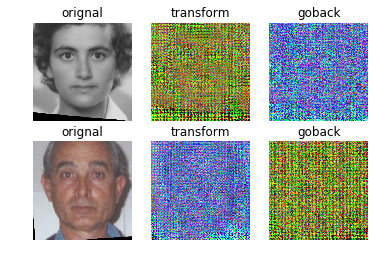

[epoch_index: 0/200][batch_index:1/9480] [D loss: 8.801604, acc:  11%] [G loss: 27.013195, adv: 5.152658, recon: 0.757954, id: 0.751537] [time:2019-08-14-164523]
[epoch_index: 0/200][batch_index:2/9480] [D loss: 9.039155, acc:  15%] [G loss: 19.624252, adv: 2.632144, recon: 0.653413, id: 0.678505] [time:2019-08-14-164524]
[epoch_index: 0/200][batch_index:3/9480] [D loss: 5.310990, acc:  14%] [G loss: 22.923853, adv: 4.198046, recon: 0.663793, id: 0.738275] [time:2019-08-14-164525]
[epoch_index: 0/200][batch_index:4/9480] [D loss: 3.916464, acc:  12%] [G loss: 22.562176, adv: 4.347454, recon: 0.634285, id: 0.572241] [time:2019-08-14-164526]
[epoch_index: 0/200][batch_index:5/9480] [D loss: 4.535392, acc:  14%] [G loss: 19.072567, adv: 2.769207, recon: 0.617876, id: 0.674111] [time:2019-08-14-164527]
[epoch_index: 0/200][batch_index:6/9480] [D loss: 2.307854, acc:  23%] [G loss: 20.009754, adv: 1.974800, recon: 0.733907, id: 0.592500] [time:2019-08-14-164528]
[epoch_index: 0/200][batch_i

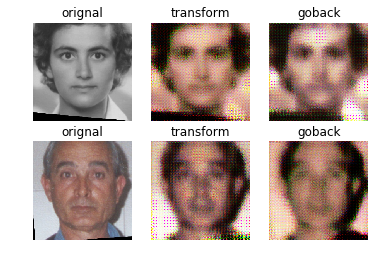

[epoch_index: 0/200][batch_index:51/9480] [D loss: 0.169125, acc:  50%] [G loss: 5.773363, adv: 0.449883, recon: 0.218603, id: 0.249119] [time:2019-08-14-164615]
[epoch_index: 0/200][batch_index:52/9480] [D loss: 0.149162, acc:  58%] [G loss: 5.256969, adv: 0.557862, recon: 0.186936, id: 0.203935] [time:2019-08-14-164616]
[epoch_index: 0/200][batch_index:53/9480] [D loss: 0.171359, acc:  53%] [G loss: 5.740359, adv: 0.449807, recon: 0.219126, id: 0.228313] [time:2019-08-14-164617]
[epoch_index: 0/200][batch_index:54/9480] [D loss: 0.198540, acc:  48%] [G loss: 5.781475, adv: 0.520092, recon: 0.213850, id: 0.243165] [time:2019-08-14-164618]
[epoch_index: 0/200][batch_index:55/9480] [D loss: 0.267419, acc:  50%] [G loss: 6.214338, adv: 0.562963, recon: 0.231607, id: 0.227631] [time:2019-08-14-164619]
[epoch_index: 0/200][batch_index:56/9480] [D loss: 0.257090, acc:  49%] [G loss: 10.482785, adv: 0.630623, recon: 0.421155, id: 0.442028] [time:2019-08-14-164620]
[epoch_index: 0/200][batch_

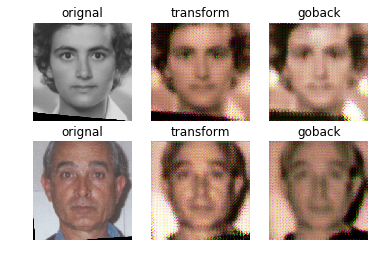

[epoch_index: 0/200][batch_index:101/9480] [D loss: 0.174912, acc:  47%] [G loss: 5.413576, adv: 0.427705, recon: 0.209004, id: 0.205863] [time:2019-08-14-164707]
[epoch_index: 0/200][batch_index:102/9480] [D loss: 0.118338, acc:  65%] [G loss: 12.277253, adv: 0.420237, recon: 0.520506, id: 0.673909] [time:2019-08-14-164708]
[epoch_index: 0/200][batch_index:103/9480] [D loss: 0.187241, acc:  48%] [G loss: 11.244040, adv: 0.423201, recon: 0.476456, id: 0.236426] [time:2019-08-14-164709]
[epoch_index: 0/200][batch_index:104/9480] [D loss: 0.131000, acc:  64%] [G loss: 9.661448, adv: 0.444033, recon: 0.400195, id: 0.566252] [time:2019-08-14-164710]
[epoch_index: 0/200][batch_index:105/9480] [D loss: 0.170736, acc:  55%] [G loss: 6.412715, adv: 0.521296, recon: 0.242633, id: 0.255237] [time:2019-08-14-164711]
[epoch_index: 0/200][batch_index:106/9480] [D loss: 0.192857, acc:  54%] [G loss: 7.610197, adv: 0.478096, recon: 0.302609, id: 0.186903] [time:2019-08-14-164712]
[epoch_index: 0/200]

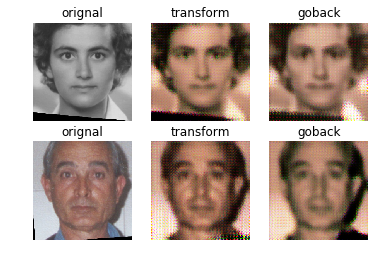

[epoch_index: 0/200][batch_index:151/9480] [D loss: 0.207969, acc:  49%] [G loss: 6.452666, adv: 0.567241, recon: 0.242319, id: 0.308999] [time:2019-08-14-164758]
[epoch_index: 0/200][batch_index:152/9480] [D loss: 0.218674, acc:  49%] [G loss: 5.224102, adv: 0.340432, recon: 0.208155, id: 0.215182] [time:2019-08-14-164759]
[epoch_index: 0/200][batch_index:153/9480] [D loss: 0.190233, acc:  47%] [G loss: 4.116019, adv: 0.310383, recon: 0.157634, id: 0.179849] [time:2019-08-14-164800]
[epoch_index: 0/200][batch_index:154/9480] [D loss: 0.132152, acc:  56%] [G loss: 5.515390, adv: 0.339737, recon: 0.220524, id: 0.243465] [time:2019-08-14-164801]
[epoch_index: 0/200][batch_index:155/9480] [D loss: 0.147760, acc:  48%] [G loss: 4.426254, adv: 0.331414, recon: 0.172174, id: 0.140740] [time:2019-08-14-164802]
[epoch_index: 0/200][batch_index:156/9480] [D loss: 0.152906, acc:  51%] [G loss: 5.026272, adv: 0.351427, recon: 0.197662, id: 0.164617] [time:2019-08-14-164803]
[epoch_index: 0/200][b

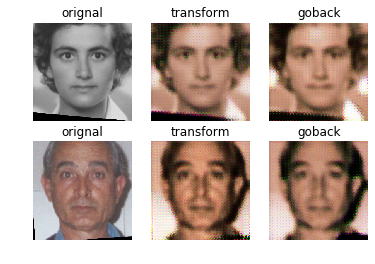

[epoch_index: 0/200][batch_index:201/9480] [D loss: 0.116768, acc:  66%] [G loss: 5.909960, adv: 0.477064, recon: 0.225825, id: 0.243714] [time:2019-08-14-164849]
[epoch_index: 0/200][batch_index:202/9480] [D loss: 0.144318, acc:  57%] [G loss: 5.541847, adv: 0.511194, recon: 0.205297, id: 0.274574] [time:2019-08-14-164850]
[epoch_index: 0/200][batch_index:203/9480] [D loss: 0.191853, acc:  40%] [G loss: 4.183010, adv: 0.283964, recon: 0.164383, id: 0.162825] [time:2019-08-14-164851]
[epoch_index: 0/200][batch_index:204/9480] [D loss: 0.137111, acc:  65%] [G loss: 6.234260, adv: 0.729548, recon: 0.219480, id: 0.247900] [time:2019-08-14-164852]
[epoch_index: 0/200][batch_index:205/9480] [D loss: 0.209842, acc:  51%] [G loss: 5.134202, adv: 0.351163, recon: 0.200431, id: 0.177403] [time:2019-08-14-164853]
[epoch_index: 0/200][batch_index:206/9480] [D loss: 0.142856, acc:  55%] [G loss: 5.657835, adv: 0.383931, recon: 0.223564, id: 0.224572] [time:2019-08-14-164854]
[epoch_index: 0/200][b

In [0]:
tb_G_loss_track.set_model(combined_model)
# tb_G_loss_track.set_model()
for epoch in range(epochs):
  
  #update learning rate (decay) for each epoch
  lr_D, lr_G = update_lr(epoch)
  kerasbackend.set_value(D_A.optimizer.lr,lr_D)
  kerasbackend.set_value(D_B.optimizer.lr,lr_D)
  kerasbackend.set_value(combined_model.optimizer.lr,lr_G)
  
  
  for batch_index, (batch_num, imgs_A, imgs_B) in enumerate(loaddata_batch(root_path, batch_size)):
    
   
    fake_B_tmp = G_A2B.predict(imgs_A)
    fake_A_tmp = G_B2A.predict(imgs_B)
    
    fake_B = image_pooling.fake_image_pooling(fake_B_tmp)
    fake_A = image_pooling.fake_image_pooling(fake_A_tmp)

    dA_loss_real = D_A.train_on_batch(imgs_A, valid)
    dA_loss_fake = D_A.train_on_batch(fake_A, fake)
    
    dA_loss = 0.5 * np.add(dA_loss_real, dA_loss_fake)
   

    dB_loss_real = D_B.train_on_batch(imgs_B, valid)
    dB_loss_fake = D_B.train_on_batch(fake_B, fake)

    dB_loss = 0.5 * np.add(dB_loss_real,dB_loss_fake)

    d_loss = 0.5 * np.add(dA_loss, dB_loss)

    #training generation
    g_loss = combined_model.train_on_batch([imgs_A, imgs_B],\
                                           [valid, valid, \
                                            imgs_A, imgs_B, \
                                            imgs_A, imgs_B])    
    
    #add tensorboard
    tb_G_loss_track.on_epoch_end(batch_index, logs=reNamed_logs(g_loss))

    #collect losses for plot
      
    DA_losses.append(dA_loss)
    DB_losses.append(dB_loss)
    
   
    time = datetime.datetime.now().strftime("%Y-%m-%d-%H%M%S")
    
    print ("[epoch_index: %d/%d][batch_index:%d/%d] [D loss: %f, acc: %3d%%] [G loss: %05f, adv: %05f, recon: %05f, id: %05f] [time:%s]" \
                                                                          % ( epoch, epochs, \
                                                                              batch_index, batch_num, \
                                                                              d_loss[0], 100*d_loss[1],\
                                                                              g_loss[0],\
                                                                              np.mean(g_loss[1:3]),\
                                                                              np.mean(g_loss[3:5]),\
                                                                              np.mean(g_loss[5:6]),\
                                                                              time))
    if batch_index % save_interval == 0:
      print("=========save model====save image===original image + reconstruct image + return original image============")
      saveimage(batch_index, epoch)
       

    training_history = {
        'DA_losses':DA_losses,
        'DB_losses':DB_losses
    }
  
  save_loss_tocsv(training_history, time)
  tb_G_loss_track.on_epoch_end(epoch)
  #save model
#   if(epoch % 10 == 0):
  save_model(epoch, D_A)
  save_model(epoch, D_B)
  save_model(epoch, combined_model)

In [0]:
 %load_ext tensorboard

In [0]:
%tensorboard --logdir cycGAN_G_loss/

In [0]:
#@title
%%writefile plot_csvplot.py
#reference https://github.com/simontomaskarlsson/CycleGAN-Keras/blob/master/plotCSVfile.py
#learning for handling 

import csv
import matplotlib.pyplot as plt
import numpy as np

from scipy.signal import butter, lfilter

def lowpassfilterandbutter(data, cutoff, fs, order=6):
    nyqz = 0.5 * fs
    normal_cutoff = cutoff / nyqz
    b, a = butter(order, normal_cutoff, btype='low')
    y = lfilter(b, a, data)
    return y

#csv loss value for each epoch
def plotlossCSV(datetime, point_gap=1):
    DA_losses = []
    DB_losses = []
    GA_fake_losses = []
    GB_fake_losses = []
    GA_recon_losses = []
    GB_recon_losses = []
    D_losses = []
    G_losses = []
    recon_losses = []

    with open('images/{}/loss_output.csv'.format(datetime+'_test'), newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            DA_losses.append(float(row['DA_losses']))
            DB_losses.append(float(row['DB_losses']))
            GA_fake_losses.append(float(row['GA_fake_losses']))
            GB_fake_losses.append(float(row['GB_fake_losses']))
            GA_recon_losses.append(float(row['GA_recon_losses']))
            GB_recon_losses.append(float(row['GB_recon_losses']))
            D_losses.append(float(row['D_losses']))
            recon_losses.append(float(row['recon_losses']))
            G_loss = row['G_losses']
            if G_loss[0] == '[':
                G_loss = G_loss.split(',')[0][1:]
            G_losses.append(float(G_loss))
        csvfile.close()

        # Calculate interesting things to plot
        DA_losses = np.array(DA_losses)
        DB_losses = np.array(DB_losses)
        GA_losses = np.add(np.array(GA_fake_losses), np.array(GA_recon_losses))
        GB_losses = np.add(np.array(GB_fake_losses), np.array(GB_recon_losses))
        RA_losses = np.array(GA_recon_losses)
        RB_losses = np.array(GB_recon_losses)

        G_losses = np.array(G_losses)
        D_losses = np.array(D_losses)
        reconstruction_losses = np.add(np.array(GA_recon_losses), np.array(GB_recon_losses))

    points = range(0, len(G_losses), point_gap)
    fs = 1000
    cutoff = 2
    order = 6

    # Lowpass filter make line is smooth
    GA = lowpassfilterandbutter(GA_losses[points], cutoff, fs, order)
    GB = lowpassfilterandbutter(GB_losses[points], cutoff, fs, order)

    DA = lowpassfilterandbutter(DA_losses[points], cutoff, fs, order)
    DB = lowpassfilterandbutter(DB_losses[points], cutoff, fs, order)

    RA = lowpassfilterandbutter(RA_losses[points], cutoff, fs, order)
    RB = lowpassfilterandbutter(RB_losses[points], cutoff, fs, order)

    G = lowpassfilterandbutter(G_losses[points], cutoff, fs, order)
    D = lowpassfilterandbutter(D_losses[points], cutoff, fs, order)
    R = lowpassfilterandbutter(reconstruction_losses[points], cutoff, fs, order)

    fig_D = plt.figure(1)
    plt.plot(GA, label='GB_losses')
    plt.plot(GB, label='GA_losses')
    plt.ylabel('Generator losses')
    plt.legend()

    fig_G = plt.figure(2)
    plt.plot(DA, label='DA_losses')
    plt.plot(DB, label='DB_losses')
    plt.ylabel('Discriminator losses')
    plt.legend()

    fig_recons = plt.figure(3)
    plt.plot(RA, label='Reconstruction_loss_A')
    plt.plot(RB, label='Reconstruction_loss_B')
    plt.ylabel('Reconstruction losses')
    plt.legend()

    fig_tots = plt.figure(4)
    plt.plot(G, label='G_losses')
    plt.plot(D, label='D_losses')
    plt.plot(R, label='Reconstruction_losses')
    plt.legend()

    # Show plots
    fig_D.show()
    fig_G.show()
    fig_recons.show()
    fig_tots.show()

    plt.pause(0)


if __name__ == '__main__':
    datetime = str(sys.argv[1])
#     datetime = "20190804-114925"
#     points = 1
    points = int(sys.argv[2])
    plotResultfromCSV(datetime, points)
